### **Section 5.6 - Precision Recall Curves**

In [1]:
import re
import os
import warnings

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from tensorflow import keras
import tensorflow

tensorflow.random.set_seed(0)

ImportError: cannot import name 'parse_version' from 'sklearn.utils' (c:\Users\manim\LabV2\Diversity Measures\diversity_measures\venv\Lib\site-packages\sklearn\utils\__init__.py)

In [ ]:
tensorflow.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

In [ ]:
ATTRIBUTES = ["majority_distance", "majority_distance_squared", "shannon_entropy", "gini_impurity"]
CLASS = 'majority_correct'
RANDOM_STATE = 42

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

def cross_val_pr_curve(classifier, X, y, n_splits=10):
    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    # Variables to store metrics
    aucs = []
    mean_recall = np.linspace(0, 1, 1000)
    precisions = []

    i = 0
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train_fold, y_train_fold)
        y_proba_fold = classifier.predict_proba(X_test_fold)

        y_proba_fold_inv = 1 - y_proba_fold[:,1]
        y_test_fold_inv = 1 - y_test_fold

        # Get precision-recall curve
        precision_fold, recall_fold, thresholds = precision_recall_curve(y_test_fold_inv, y_proba_fold_inv)
        precision_fold = precision_fold[:-1]
        recall_fold = recall_fold[:-1]

        # Interpolate precision for mean recall values
        interp_precision = np.interp(mean_recall, recall_fold[::-1], precision_fold[::-1])
        precisions.append(interp_precision)
        # aucs.append(auc(mean_recall, interp_precision))

        # Compute the AUPRC
        auprc = average_precision_score(y_test_fold, y_proba_fold[:, 1])
        aucs.append(auprc)

        i += 1

    # Compute average precision across all folds
    mean_precision = np.mean(precisions, axis=0)

    mean_auprc = np.mean(aucs)


    return mean_recall, mean_precision, mean_auprc

In [ ]:
class MLExploration:
    def __init__(self, data_x, data_y, scoring, output_file_path):
        self.data_x = data_x
        self.data_y = data_y
        self.scoring = scoring
        self.output_file_path = output_file_path
        self.explored_models = pandas.DataFrame()
        if os.path.exists(output_file_path):
            self.explored_models = pandas.read_json(output_file_path, lines=True)

    def explore_model(self, clf, sampler):
        clf_hash = self.__hash_model(clf)
        sampler_hash = self.__hash_model(sampler)
        index = str((clf_hash, sampler_hash))

        if sampler == None:
            model = clf
        else:
            model = Pipeline([("sampler", sampler), ("clf", clf)])

        recall, precision, aucs = cross_val_pr_curve(model, self.data_x, self.data_y, 5)

        if not (
            "id" in self.explored_models.columns
            and (self.explored_models["id"].eq(index)).any()
        ):
            results = cross_validate(
                estimator=model, X=self.data_x, y=self.data_y, scoring=self.scoring
            )
            row = pandas.DataFrame(
                [
                    {
                        "id": index,
                        "clf": clf_hash,
                        "sampler": sampler_hash,
                        **self.__dict_mean(results),
                    }
                ]
            )
            self.explored_models = pandas.concat([self.explored_models, row])
            self.explored_models.to_json(
                self.output_file_path, lines=True, orient="records"
            )
        
        # Plotting code always runs
        self.plot_model(recall, precision, clf_hash)



    def plot_model(self, recall, precision, clf_hash):
        print(clf_hash)
        plt.figure(figsize=(8, 6))
        plt.step(recall, precision, color="k", where="post")

        no_skill = 1 - sum(self.data_y == 1) / len(self.data_y)  # compute the prior

        plt.plot(
            [0, 1], [no_skill, no_skill], linestyle="--", color="grey"
        )  

        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.ylim([0, 1])
        plt.xlim([0, 1])
        plt.grid(True)
        plt.tick_params(axis="both", which="major", labelsize=14)

        # Calculating the area under the precision-recall curve
        auc_score = auc(recall, precision)
        print(f"Area Under Curve: {auc_score}")

        plt.show()


    def __dict_mean(self, obj):
        try:
            return sum(obj) / len(obj)
        except:
            return {
                key.replace("test_", ""): self.__dict_mean(obj[key])
                for key in obj.keys()
            }

    def __hash_model(self, clf):
        if type(clf) == KerasClassifier:
            cleaned = re.sub(r"\n\tmodel\=.*\n", "", str(clf), re.DOTALL)
            cleaned = re.sub(r"\n", ",", cleaned, re.DOTALL)
            cleaned = re.sub(r"\t", "", cleaned, re.DOTALL)
            return str((cleaned, self.__keras_model_info(clf)))
        return str(clf)

    def __keras_model_info(self, clf):
        return str(
            [
                (type(layer).__name__, layer.units, layer.activation.__name__)
                for layer in clf.model.layers
            ]
        )

In [ ]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision-Incorrect": make_scorer(precision_score, pos_label=0),
    "recall-Incorrect": make_scorer(recall_score, pos_label=0),
    "f1-Incorrect": make_scorer(f1_score, pos_label=0),
    "precision-Correct": make_scorer(precision_score, pos_label=1),
    "recall-Correct": make_scorer(recall_score, pos_label=1),
    "f1-Correct": make_scorer(f1_score, pos_label=1),
}

In [ ]:
def create_model(n_features, n_layers, units, hidden_activation, output_activation, step_size=2):
    model = Sequential()
    step = -step_size
    for i in range(n_layers):
        if i == 0:
            model.add(Dense(units, input_dim=n_features, activation=hidden_activation)) 
 
        else:
            if step == 0: units = max(1, units // 2)
            model.add(Dense(units, activation=hidden_activation))

        step = (step + 1) % step_size

    model.add(Dense(1, activation=output_activation))   
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

('KerasClassifier(build_fn=None,warm_start=False,random_state=None,optimizer=rmsprop,loss=None,metrics=None,batch_size=128,validation_batch_size=None,verbose=0,callbacks=None,validation_split=0.0,shuffle=True,run_eagerly=False,epochs=100,class_weight=None,)', "[('Dense', 100, 'relu'), ('Dense', 100, 'relu'), ('Dense', 50, 'relu'), ('Dense', 50, 'relu'), ('Dense', 25, 'relu'), ('Dense', 25, 'relu'), ('Dense', 12, 'relu'), ('Dense', 12, 'relu'), ('Dense', 6, 'relu'), ('Dense', 6, 'relu'), ('Dense', 1, 'sigmoid')]")
Area Under Curve: 0.5248246689281968


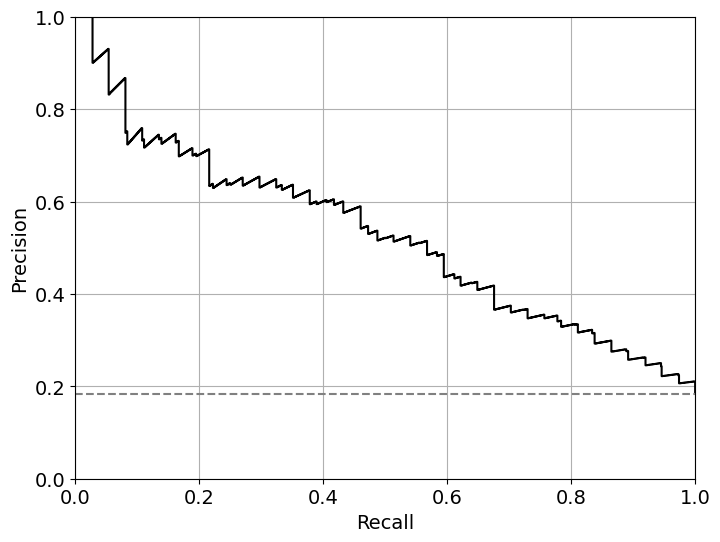

('KerasClassifier(build_fn=None,warm_start=False,random_state=None,optimizer=rmsprop,loss=None,metrics=None,batch_size=128,validation_batch_size=None,verbose=0,callbacks=None,validation_split=0.0,shuffle=True,run_eagerly=False,epochs=100,class_weight=None,)', "[('Dense', 100, 'relu'), ('Dense', 100, 'relu'), ('Dense', 50, 'relu'), ('Dense', 50, 'relu'), ('Dense', 25, 'relu'), ('Dense', 25, 'relu'), ('Dense', 12, 'relu'), ('Dense', 12, 'relu'), ('Dense', 6, 'relu'), ('Dense', 6, 'relu'), ('Dense', 1, 'sigmoid')]")
Area Under Curve: 0.5473820809084675


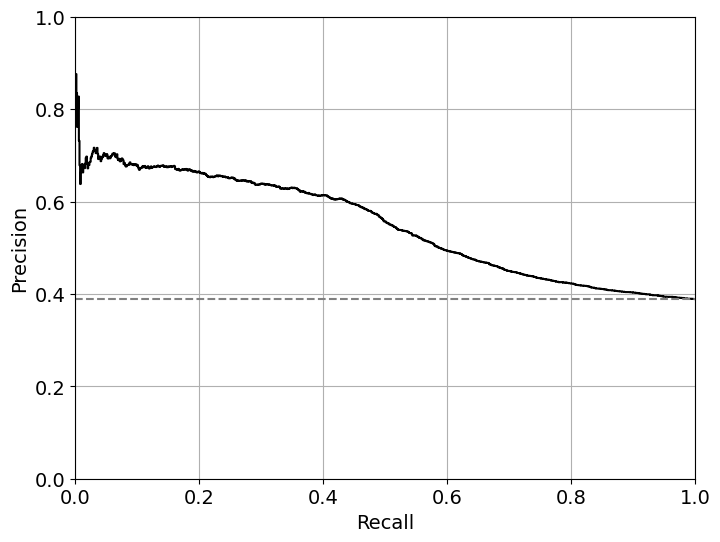

('KerasClassifier(build_fn=None,warm_start=False,random_state=None,optimizer=rmsprop,loss=None,metrics=None,batch_size=128,validation_batch_size=None,verbose=0,callbacks=None,validation_split=0.0,shuffle=True,run_eagerly=False,epochs=100,class_weight=None,)', "[('Dense', 100, 'relu'), ('Dense', 100, 'relu'), ('Dense', 50, 'relu'), ('Dense', 50, 'relu'), ('Dense', 25, 'relu'), ('Dense', 25, 'relu'), ('Dense', 12, 'relu'), ('Dense', 12, 'relu'), ('Dense', 6, 'relu'), ('Dense', 6, 'relu'), ('Dense', 1, 'sigmoid')]")
Area Under Curve: 0.70581550817356


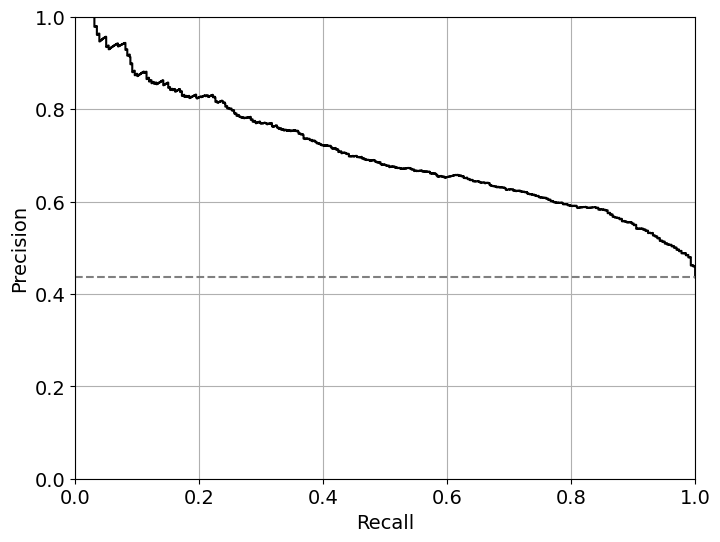

In [ ]:
for file_path, cache_file_path in [
    ('../../data/machine-learning/draw/draw-T0.7.jsonl', '../../cache/machine-learning/draw/draw-T0.7.json'),
    ('../../data/machine-learning/csqa/csqa-T0.7.jsonl', '../../cache/machine-learning/csqa/csqa-T0.7.json'),
    ('../../data/machine-learning/last_letters/last_letters-T0.7.jsonl', '../../cache/machine-learning/last_letters/last_letters-T0.7.json'),
    ('../../data/machine-learning/svamp/svamp-T0.7.jsonl', '../../cache/machine-learning/svamp/svamp-T0.7.json'),
    ('../../data/machine-learning/stqa/stqa-T0.7.jsonl', '../../cache/machine-learning/stqa/stqa-T0.7.json'),

]:
    cache_dir_name = os.path.dirname(cache_file_path)
    if not os.path.isdir(cache_dir_name): os.makedirs(cache_dir_name)

    data = pandas.read_json(file_path, lines=True)
    data_x = data[ATTRIBUTES]
    data_y = data[CLASS]

    ml_exploration = MLExploration(
        data_x=data_x, data_y=data_y, output_file_path=cache_file_path, scoring=scoring
    )

    for sampler in [
        # None,
        RandomOverSampler(random_state=0),
        # RandomUnderSampler(random_state=RANDOM_STATE)
    ]:
        ml_exploration.explore_model(clf=KerasClassifier(model=create_model(len(ATTRIBUTES), 10, 100, 'relu', 'sigmoid', step_size=2), verbose=0, epochs=100, batch_size=128), sampler=sampler)